Epoch 1/50


<ipython-input-1-3deaca72a61f>:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = daily_df["daily_cases"].resample("M").mean().reset_index()
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.2730 - val_loss: 0.8286
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - loss: 0.2683 - val_loss: 0.8167
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 0.2639 - val_loss: 0.8050
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.2594 - val_loss: 0.7932
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.2548 - val_loss: 0.7809
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.2501 - val_loss: 0.7683
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2454 - val_loss: 0.7555
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2406 - val_loss: 0.7424
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.2358 - val_loss: 0.7292
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.2309 - val_loss: 0.7157
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.2259 - val_loss: 0.7020
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.2209 - val_loss: 0.6880
Epoch 

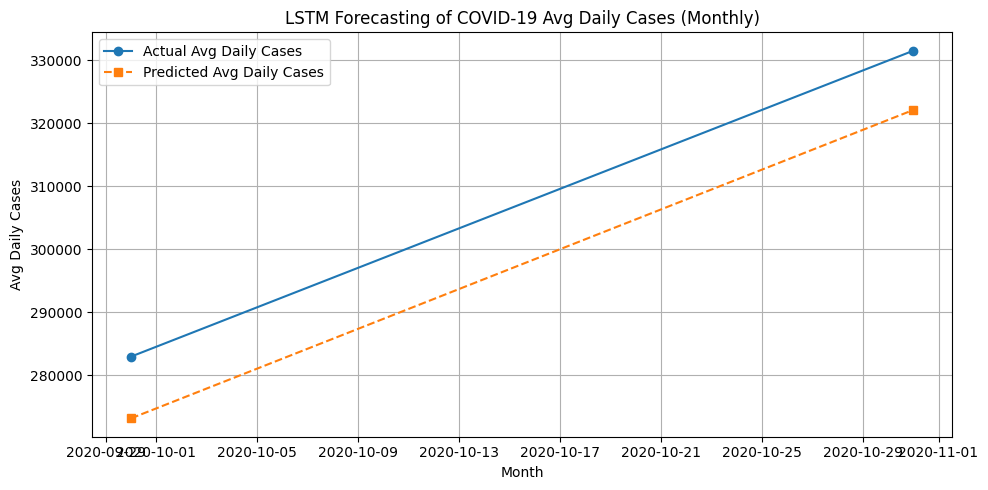

In [1]:
# Install TensorFlow if not installed
!pip install tensorflow --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the COVID-19 dataset
df = pd.read_csv("/time-series-19-covid-combined.csv")

# Preprocessing
df.columns = df.columns.str.strip()
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# Calculate daily new global cases
daily_df = df.groupby(df.index).sum(numeric_only=True)
daily_df["daily_cases"] = daily_df["Confirmed"].diff()
daily_df.dropna(subset=["daily_cases"], inplace=True)

# Resample to monthly average daily cases
monthly_avg = daily_df["daily_cases"].resample("M").mean().reset_index()
monthly_avg.set_index("Date", inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
monthly_avg["cases_scaled"] = scaler.fit_transform(monthly_avg[["daily_cases"]])

# Create dataset for LSTM
def create_dataset(data, time_steps=3):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Prepare sequences
time_steps = 3
X, y = create_dataset(monthly_avg["cases_scaled"].values, time_steps)

# Reshape input to [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), verbose=1)

# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting results
test_dates = monthly_avg.index[-len(y_test):]

plt.figure(figsize=(10, 5))
plt.plot(test_dates, y_test_actual, label="Actual Avg Daily Cases", marker='o')
plt.plot(test_dates, y_pred_actual, label="Predicted Avg Daily Cases", linestyle='dashed', marker='s')
plt.xlabel("Month")
plt.ylabel("Avg Daily Cases")
plt.title("LSTM Forecasting of COVID-19 Avg Daily Cases (Monthly)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
